# centreOptimiser

Once you have created your geometry via geoAssembler, there's a good chance that the centre of the geometry is not the centre of the beam. This can very negatively effect the results of azimuthal integration, or any other form of analysis which requires precise knowledeg of the centre of the beam.

centreOptimiser was created to solve this problem, it uses data from sharp diffraction rings (e.g. from Lithium Titanate powder) to improve the geometry further.

It can be imported from geoAssembler as:

In [1]:
import geoAssembler.optimiser as centreOptimiser

From here import all of the packages you would normally use:

In [2]:
from extra_data import RunDirectory, stack_detector_data
from extra_geom import AGIPD_1MGeometry

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import os.path

Optionally if you want to use multiprocessing to speed up the optimisation process you can also import `Pool` out of the multiprocessing module:

In [5]:
from multiprocessing import Pool

Now create a geomtery and run object:

In [6]:
geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=[
        (-525, 625),
        (-550, -10),
        (520, -160),
        (542.5, 475),
    ])

In [7]:
run_path = '/gpfs/exfel/exp/SPB/201831/p900039/proc/r0273/'
run_available = os.path.isdir(run_path)
if run_available:
    run = RunDirectory('/gpfs/exfel/exp/SPB/201831/p900039/proc/r0273/')
else:
    print("Run not available, falling back to using saved frame")

centreOptimiser provides a convenient averaging function for AGIPD which applies some additional masking (e.g. to the edges of the ASICS and to known bad regions of the detector), this does not need to be used though, any 2d array can be used with the optimiser

In [8]:
if run_available:
    run = run.select('*/DET/*', 'image.*')
    train_data = run.train_from_index(train_index)[1]

    # We avoid the first/last pulses, as in this case they are of worse quality than
    # the other pulses 
    stacked_image = stack_detector_data(train_data, 'image.data')[10:-10]
    stacked_mask = stack_detector_data(train_data, 'image.mask')[10:-10]

    # Any non-zero masks are set to nan
    stacked_image[stacked_mask > 0] = np.nan

    # Sub-zero and very large values set to nan
    stacked_image[stacked_image < 0] = np.nan
    stacked_image[stacked_image > 1e5] = np.nan

    stacked_mean = np.nanmean(stacked_image, axis=0)
    stacked_mean = np.clip(stacked_mean, 0, 1024)

    # ASIC edges have double pixels, we can mask those off here
    edge_mask = np.full((8, 16, 512//8, 128), np.nan)
    edge_mask[:, :, 1:-1, :] = 1
    edge_mask = edge_mask.reshape((16, 512, 128))

    stacked_mean = stacked_mean * edge_mask

    frame, centre = geom.position_modules_fast(stacked_mean)
else:
    print("Run not available, falling back to using saved frame")
    saved_frame_path = os.path.join(
        os.path.dirname(centreOptimiser.__file__), "..", "tests", "optimiser-test-frame.npy")
    frame = np.load(saved_frame_path)

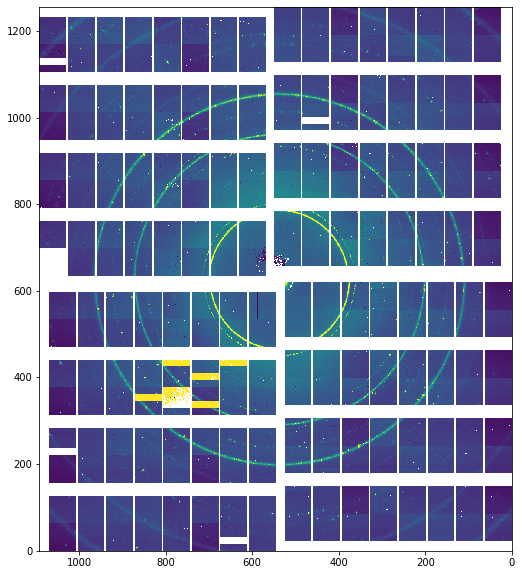

In [9]:
plt.figure(figsize=(12, 10))
plt.imshow(frame, origin='lower', interpolation='none')
plt.gca().invert_xaxis()

Creating the optimiser requires the geometry object, the frame, and the distance to the samlpe in m:

In [10]:
optimiser = centreOptimiser.CentreOptimiser(geom, frame, sample_dist_m=0.2)

The optimiser can then perform '2d integration', which just unrolls the frame around the centre:

In [11]:
missaligned_2dint = optimiser.integrate2d(frame).intensity
missaligned_2dint_r = optimiser.integrate2d(frame).radial
missaligned_2dint_a = optimiser.integrate2d(frame).azimuthal

#  Ignoring the first/last 100 radial pixels as these regions are very
#  distorted, and the integration results there are not reliable
missaligned_1dint = np.nanmean(missaligned_2dint, axis=0)[100:-100]
missaligned_1dint_x = optimiser.integrate2d(frame).radial[100:-100]

In [12]:
brightest_ring_idx = np.where(missaligned_1dint == np.nanmax(missaligned_1dint))[0][0] + 100

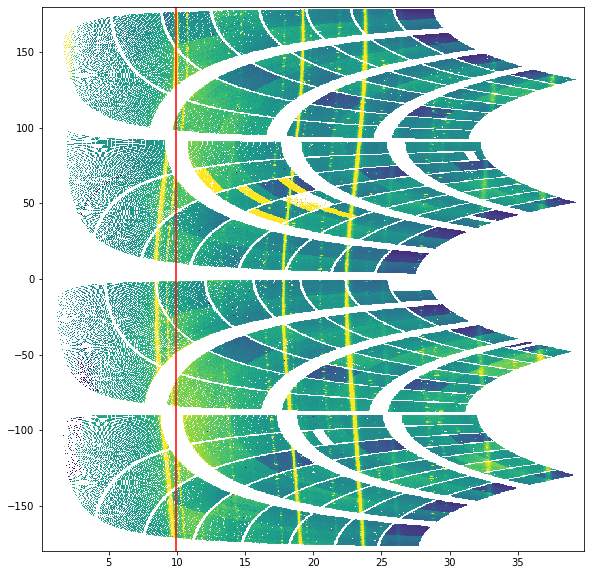

In [13]:
plt.figure(figsize=(12, 10))
plt.imshow(np.clip(missaligned_2dint, 0, 600),
    extent=(
        min(missaligned_2dint_r), max(missaligned_2dint_r),
        min(missaligned_2dint_a), max(missaligned_2dint_a)
    ),
   aspect=(max(missaligned_2dint_r)/max(missaligned_2dint_a)/2),
   interpolation='nearest'
)
plt.axvline(missaligned_2dint_r[brightest_ring_idx], color='r')

Above you can see that the circular diffraction rings are now lines, however these lines are slightly curved/wavy. This wavyness indicates that the centre of the geometry is not the same as the centre of the diffraction rings.

Performing azimuthal integration when the centre is not correct will smear out the rings over a wide area, reducing the overall signal and very negatively affecting the results you receive:

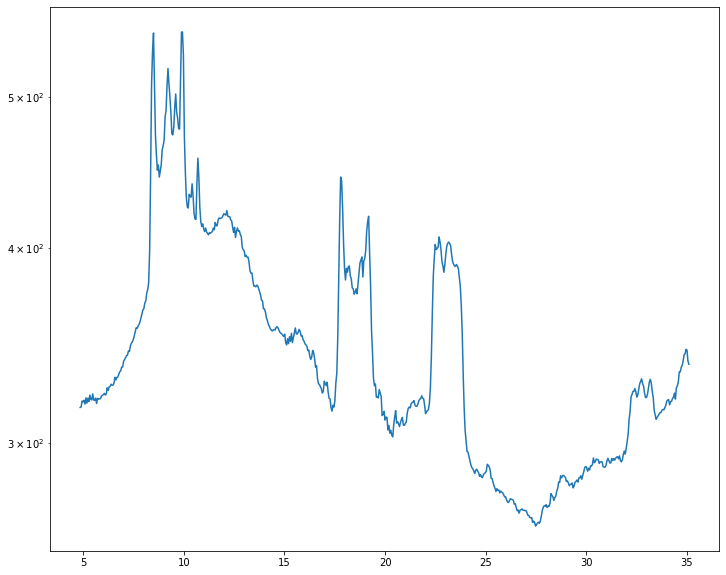

In [14]:
plt.figure(figsize=(12, 10))
plt.plot(missaligned_1dint_x, missaligned_1dint)
plt.yscale('log')

To correct for this, call the `optimise` method of the optimiser object:

In [15]:
%%time
res = optimiser.optimise(workers=1) # Single process

Optimal quad positions:  [
    (-512.2033926605434, 629.6766004523533),
    (-537.2033926605434, -5.323399547646693),
    (532.7966073394566, -155.3233995476467),
    (555.2966073394566, 479.6766004523533),
]
CPU times: user 3min 46s, sys: 356 ms, total: 3min 47s
Wall time: 3min 47s


In [16]:
%%time
# Optionally - **if you are running this on  a dedicated node**
# you can set workers to the number of parallel processes you
# want to use, or set it to -1 to use as many processes as possible
res = optimiser.optimise(workers=-1) # Parallel

Optimal quad positions:  [
    (-512.3331545661321, 629.792800176996),
    (-537.3331545661321, -5.207199823003968),
    (532.6668454338679, -155.20719982300398),
    (555.1668454338679, 479.792800176996),
]
CPU times: user 6.05 s, sys: 4 s, total: 10 s
Wall time: 34.4 s


The output of the optimisationis an object which contains the corrected quadrant corner positions, optimal centre offset, as well as all of the result object of the scipy optimiser.

You can now use the optimal quad positions to create a corrected geometry:

In [17]:
corrected_geom = geom = AGIPD_1MGeometry.from_quad_positions(
    quad_pos=res.optimal_quad_positions
)

In [18]:
corrected_optimiser = centreOptimiser.CentreOptimiser(corrected_geom, frame, sample_dist_m=0.2)

In [19]:
corrected_2dint = corrected_optimiser.integrate2d(frame).intensity
corrected_2dint_r = corrected_optimiser.integrate2d(frame).radial
corrected_2dint_a = corrected_optimiser.integrate2d(frame).azimuthal

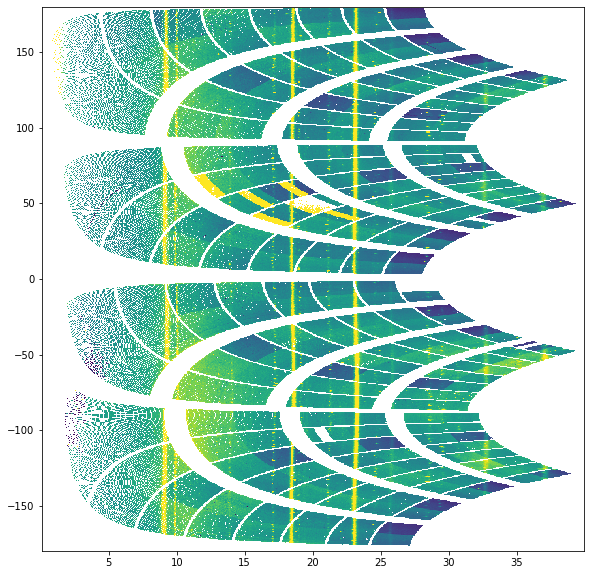

In [20]:
plt.figure(figsize=(12, 10))
plt.imshow(np.clip(corrected_2dint, 0, 600),
    extent=(
        min(corrected_2dint_r), max(corrected_2dint_r),
        min(corrected_2dint_a), max(corrected_2dint_a)
    ),
   aspect=(max(corrected_2dint_r)/max(corrected_2dint_a)/2),
   interpolation='nearest'
)

As you can see, the wavy lines are now much straighter. Performing azimuthal integration on this will now show:

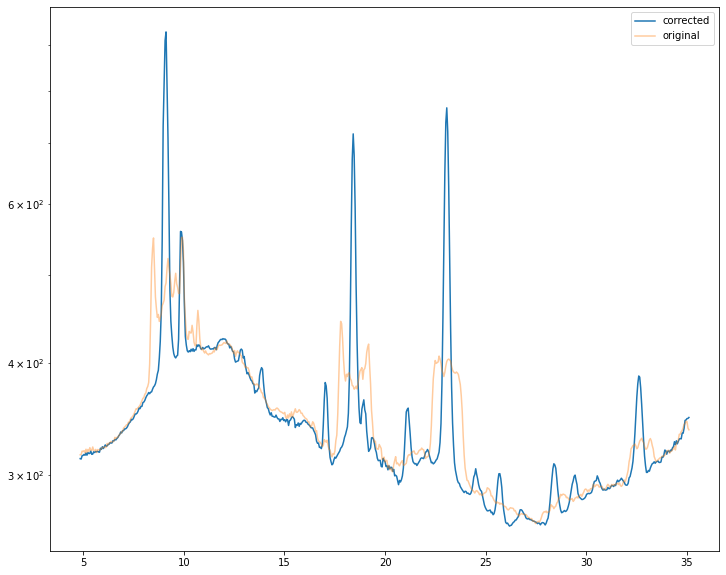

In [21]:
plt.figure(figsize=(12, 10))
plt.plot(missaligned_1dint_x, (np.nanmean(corrected_2dint, axis=0)[100:-100]), label="corrected")
plt.plot(missaligned_1dint_x, (missaligned_1dint), label="original", alpha=0.4)
plt.yscale('log')
plt.legend()

Which is a massive improvement over the previous result.